# Q-Learning for Chemical Reactor Control

This notebook demonstrates Q-learning for controlling a discrete chemical reactor environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Import the reactor environment
from env.cstr import DiscreteReactorWrapper
from pcgym import make_env

# Set random seed
np.random.seed(42)

## Create Environment

In [ ]:
def create_reactor_env():
    # Environment parameters
    nsteps = 60
    T = 26.0
    goal_state = 0.86
    SP = {
        'Ca': [goal_state for i in range(int(nsteps))],
    }
    
    # Action and observation spaces
    action_space = {
        'low': np.array([295.]),
        'high': np.array([302.])
    }
    observation_space = {
        'low': np.array([0.7, 315., 0.8], dtype=np.float32),
        'high': np.array([0.9, 335., 0.9], dtype=np.float32),
    }
    
    # Reward scale
    r_scale = {'Ca': 1e3}
    
    # Environment parameters
    env_params = {
        'N': nsteps,
        'tsim': T,
        'SP': SP,
        'o_space': observation_space,
        'a_space': action_space,
        'x0': np.array([0.7, 330, 0.8]),
        'model': 'cstr',
        'r_scale': r_scale,
        'normalise_a': True,
        'normalise_o': True,
        'noise': True,
        'integration_method': 'casadi',
        'noise_percentage': 0.001,
    }

    # Create environment
    env = make_env(env_params)
    wrapped_env = DiscreteReactorWrapper(env, grid_size=(10, 10), goal_state=goal_state)
    
    return wrapped_env

# Create environment
disc_env = create_reactor_env()

## Q-Learning Agent

In [3]:
class QLearningAgent:
    def __init__(self, state_dim, action_dim, learning_rate=0.1, discount_factor=0.99, 
                 exploration_rate=1.0, exploration_decay=0.995, min_exploration_rate=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.min_epsilon = min_exploration_rate
        
        # Initialize Q-table
        self.q_table = np.zeros(state_dim + (action_dim,))
        
        # Training metrics
        self.rewards_history = []
        self.epsilon_history = []
    
    def choose_action(self, state):
        # Explore: choose random action
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.action_dim)
        # Exploit: choose best action
        else:
            state_tuple = tuple(state)
            return np.argmax(self.q_table[state_tuple])
    
    def update(self, state, action, reward, next_state, done):
        state_tuple = tuple(state)
        next_state_tuple = tuple(next_state)
        
        # Current Q-value
        current_q = self.q_table[state_tuple][action]
        
        # Best Q-value for next state
        best_next_q = np.max(self.q_table[next_state_tuple]) if not done else 0
        
        # Q-learning update formula
        target_q = reward + self.gamma * best_next_q
        self.q_table[state_tuple][action] = current_q + self.lr * (target_q - current_q)
    
    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
        self.epsilon_history.append(self.epsilon)

## Train the Agent

In [ ]:
# Initialize the agent
agent = QLearningAgent(
    state_dim=disc_env.grid_size,     # (10, 10)
    action_dim=disc_env.n_actions,    # 7
    learning_rate=0.1,
    discount_factor=0.99,
    exploration_rate=1.0,
    exploration_decay=0.99,
    min_exploration_rate=0.01
)

# Training parameters
num_episodes = 300
max_steps = 30

# Training loop
episode_rewards = []
episode_steps = []
progress_bar = tqdm(range(num_episodes), desc="Training Progress")

for episode in progress_bar:
    state, _ = disc_env.reset()
    total_reward = 0
    done = False
    step = 0
    
    while not done and step < max_steps:
        # Choose and take action
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated, _ = disc_env.step(action)
        done = terminated or truncated
        
        # Update Q-values
        agent.update(state, action, reward, next_state, done)
        
        state = next_state
        total_reward += reward
        step += 1
    
    agent.decay_epsilon()
    episode_rewards.append(total_reward)
    episode_steps.append(step)
    
    # Update progress bar
    progress_bar.set_postfix({
        'Reward': f"{total_reward:.2f}", 
        'Epsilon': f"{agent.epsilon:.3f}"
    })

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

## Plot Training Progress

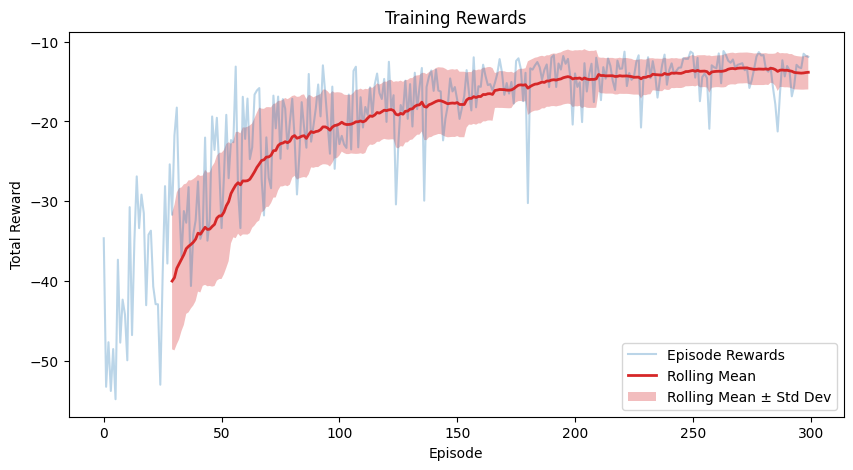

In [5]:
# Plot training rewards
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label='Episode Rewards', alpha=0.3)
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# Add smoothed trend line
window_size = min(30, len(episode_rewards))
smoothed_rewards = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
x_values = range(window_size-1, len(episode_rewards))
plt.plot(x_values, smoothed_rewards, 'tab:red', linewidth=2, label='Rolling Mean')

# Calculate rolling standard deviation
rolling_std = np.array([np.std(episode_rewards[max(0, i-window_size+1):i+1]) for i in range(window_size-1, len(episode_rewards))])

# Add the standard deviation as a fill between area around the rolling mean
plt.fill_between(x_values, smoothed_rewards - rolling_std, smoothed_rewards + rolling_std, 
                  alpha=0.3, color='tab:red', label='Rolling Mean ± Std Dev', edgecolor='none')

plt.legend()
plt.show()

## Visualize Learned Policy

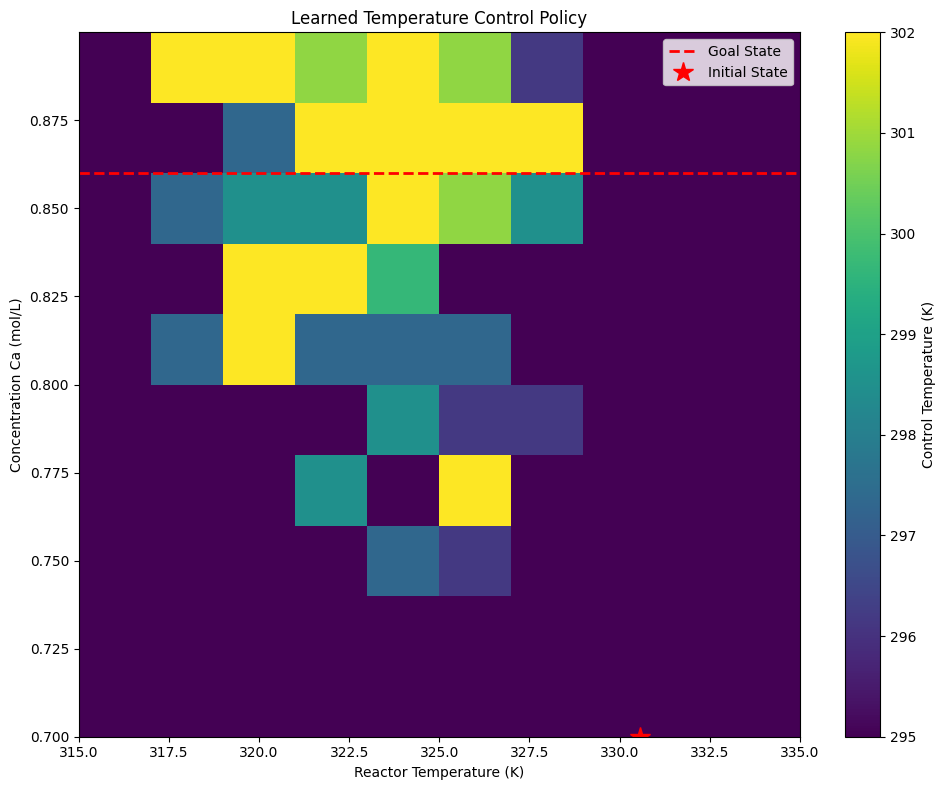

In [ ]:
# Create a policy map
policy = np.argmax(agent.q_table, axis=2)

# Convert policy indices to actual temperature values
action_space = np.linspace(295, 302, disc_env.n_actions)
real_actions = action_space[policy]

# Create actual state space values for axes
ca_space = np.linspace(disc_env.cont_obs_low[0], 
     disc_env.cont_obs_high[0], 
     disc_env.grid_size[0])
temp_space = np.linspace(disc_env.cont_obs_low[1], 
         disc_env.cont_obs_high[1], 
         disc_env.grid_size[1])

plt.figure(figsize=(10, 8))
policy_map = plt.imshow(real_actions, 
          extent=[temp_space[0], temp_space[-1], 
            ca_space[0], ca_space[-1]], 
          aspect='auto',
          cmap='viridis',
          origin='lower')

plt.colorbar(policy_map, label='Control Temperature (K)')
plt.title('Learned Temperature Control Policy')
plt.xlabel('Reactor Temperature (K)')
plt.ylabel('Concentration Ca (mol/L)')

# Mark the goal state region
plt.axhline(y=disc_env.goal_state, color='red', linestyle='--', linewidth=2, label='Goal State')

# Mark initial state
initial_obs = disc_env.reset()[0]

init_temp = disc_env.cont_obs_low[1] + (initial_obs[1] / (disc_env.grid_size[1] - 1)) * (disc_env.cont_obs_high[1] - disc_env.cont_obs_low[1])
init_ca = disc_env.cont_obs_low[0] + (initial_obs[0] / (disc_env.grid_size[0] - 1)) * (disc_env.cont_obs_high[0] - disc_env.cont_obs_low[0])
# init_temp = temp_space[initial_obs[1]]
# init_ca = ca_space[initial_obs[0]]

plt.plot(init_temp, init_ca, 'r*', markersize=15, label='Initial State')

plt.legend()
plt.tight_layout()
plt.show()


<Figure size 1500x1000 with 0 Axes>

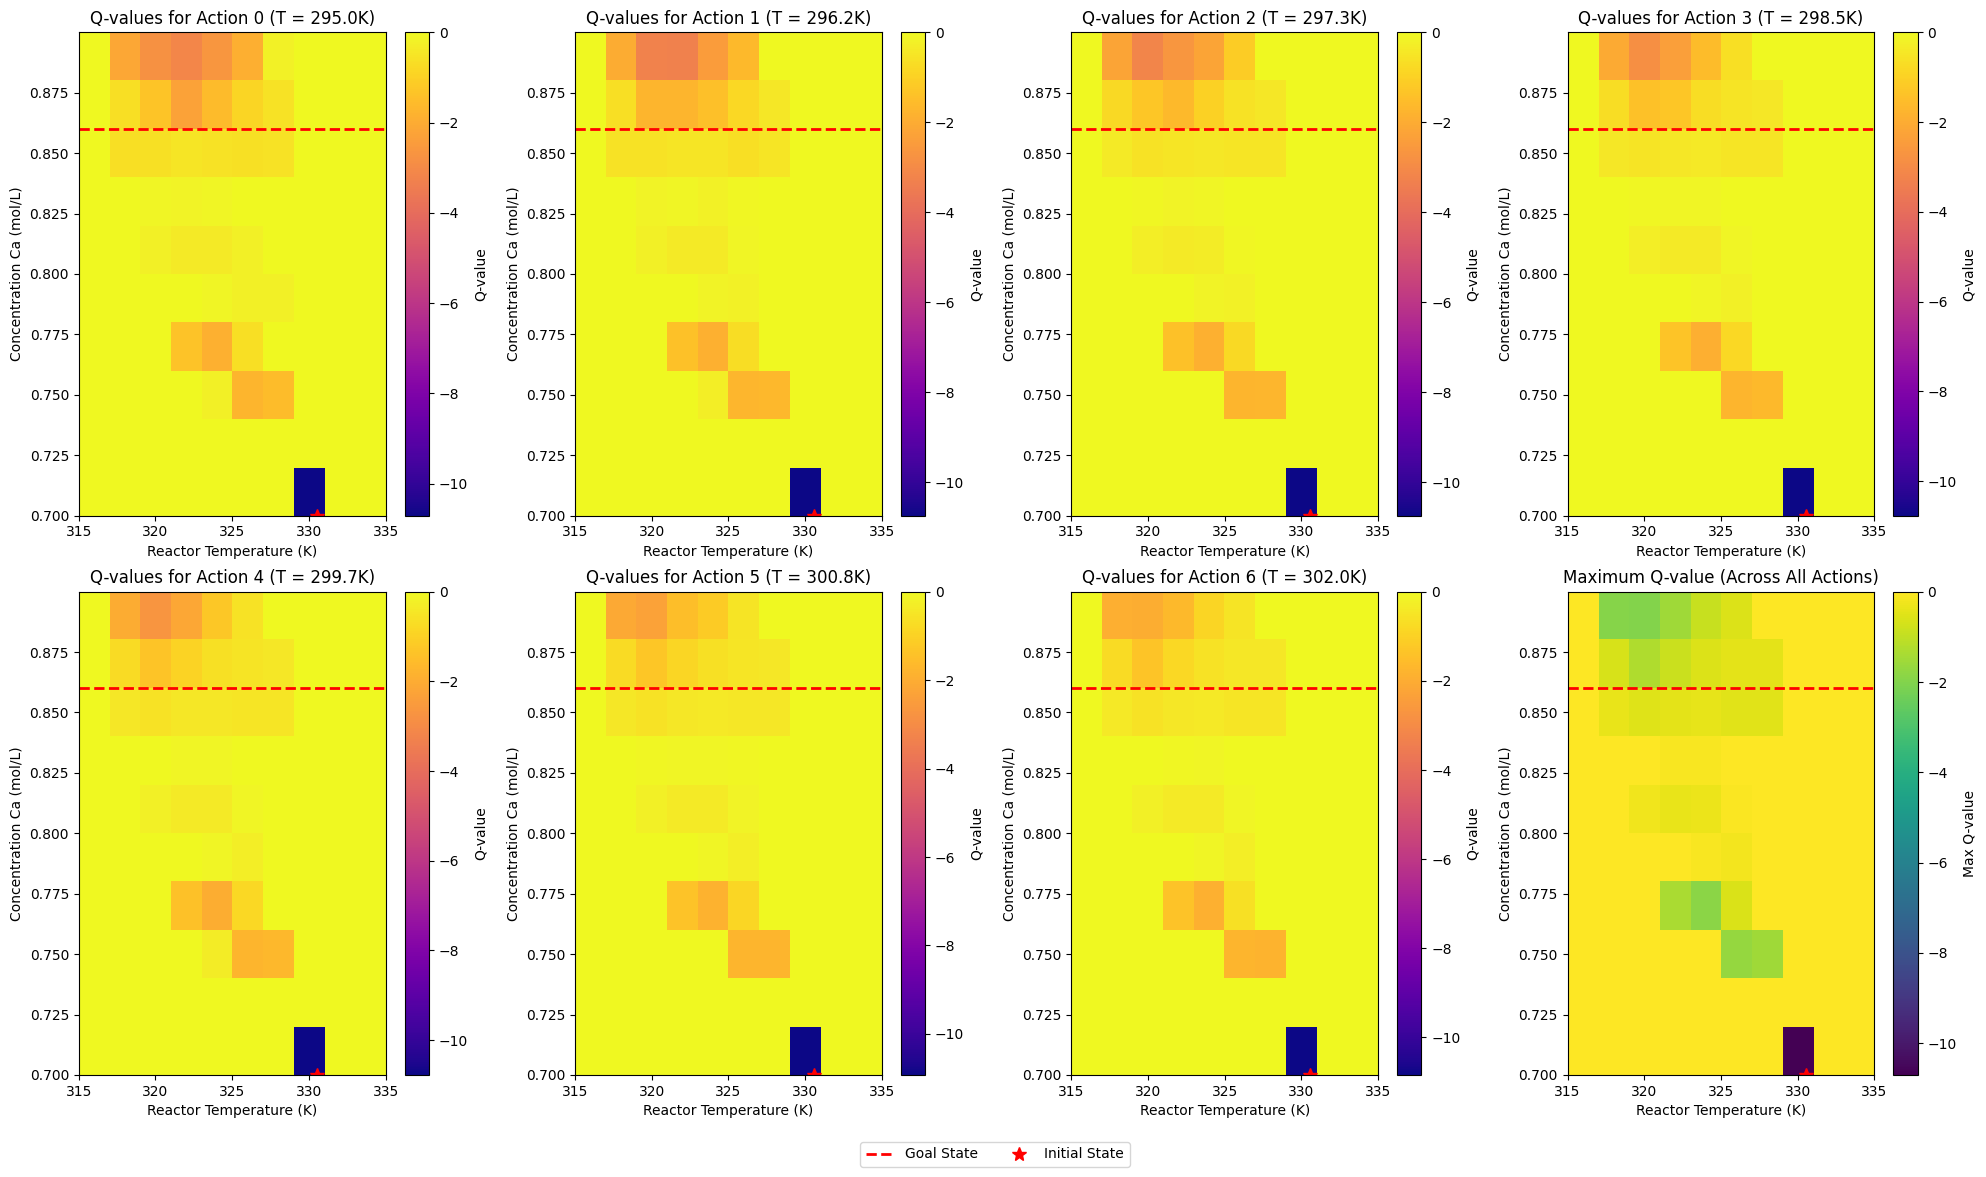

In [ ]:
# Create a figure for visualizing the Q-values
plt.figure(figsize=(15, 10))


# Create actual state space values for axes
ca_space = np.linspace(disc_env.cont_obs_low[0], 
     disc_env.cont_obs_high[0], 
     disc_env.grid_size[0])
temp_space = np.linspace(disc_env.cont_obs_low[1], 
         disc_env.cont_obs_high[1], 
         disc_env.grid_size[1])

# Create subplot for each action
n_actions = disc_env.n_actions
fig, axs = plt.subplots(2, (n_actions+1)//2, figsize=(20, 12))
axs = axs.flatten()

for action in range(n_actions):
    # Extract Q-values for this specific action
    q_values_for_action = agent.q_table[:, :, action]
    
    # Create the heatmap
    im = axs[action].imshow(q_values_for_action, 
              extent=[temp_space[0], temp_space[-1], 
                ca_space[0], ca_space[-1]], 
              aspect='auto',
              cmap='plasma',
              origin='lower')
    
    # Add colorbar and labels
    plt.colorbar(im, ax=axs[action], label='Q-value')
    axs[action].set_title(f'Q-values for Action {action} (T = {action_space[action]:.1f}K)')
    axs[action].set_xlabel('Reactor Temperature (K)')
    axs[action].set_ylabel('Concentration Ca (mol/L)')
    
    # Mark the goal state region
    axs[action].axhline(y=disc_env.goal_state, color='red', linestyle='--', linewidth=2, label='Goal State')
    
    # Mark initial state
    initial_obs = disc_env.reset()[0]
    init_temp = disc_env.cont_obs_low[1] + (initial_obs[1] / (disc_env.grid_size[1] - 1)) * (disc_env.cont_obs_high[1] - disc_env.cont_obs_low[1])
    init_ca = disc_env.cont_obs_low[0] + (initial_obs[0] / (disc_env.grid_size[0] - 1)) * (disc_env.cont_obs_high[0] - disc_env.cont_obs_low[0])
    axs[action].plot(init_temp, init_ca, 'r*', markersize=10, label='Initial State')

# Add a plot for the max Q-value (which determines the policy)
max_q_values = np.max(agent.q_table, axis=2)
im = axs[-1].imshow(max_q_values, 
          extent=[temp_space[0], temp_space[-1], 
            ca_space[0], ca_space[-1]], 
          aspect='auto',
          cmap='viridis',
          origin='lower')
plt.colorbar(im, ax=axs[-1], label='Max Q-value')
axs[-1].set_title('Maximum Q-value (Across All Actions)')
axs[-1].set_xlabel('Reactor Temperature (K)')
axs[-1].set_ylabel('Concentration Ca (mol/L)')
axs[-1].axhline(y=disc_env.goal_state, color='red', linestyle='--', linewidth=2, label='Goal State')
axs[-1].plot(init_temp, init_ca, 'r*', markersize=10, label='Initial State')

# Only include one legend for the last subplot
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # Make room for the common legend
plt.show()

## Test the Learned Policy

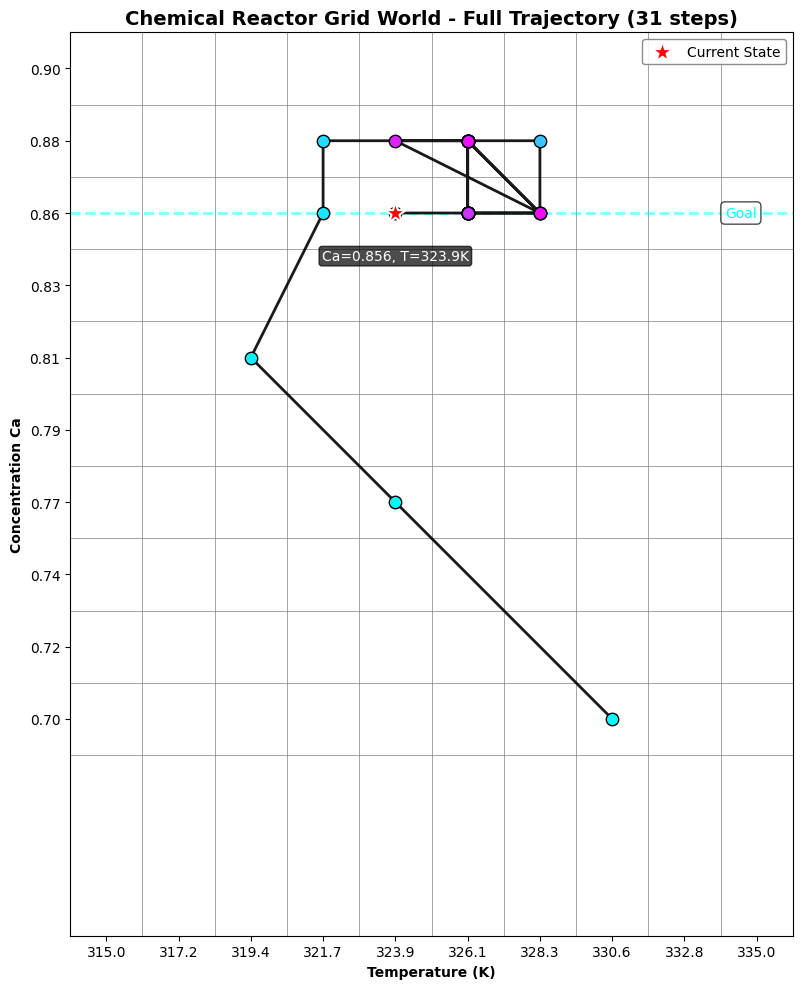


Test complete!
Total reward: -11.4847
Steps taken: 30


In [ ]:
# Test the learned policy
state, _ = disc_env.reset()
total_reward = 0
done = False
step = 0

while not done and step < max_steps:
    # Choose best action according to Q-table
    state_tuple = tuple(state)
    action = np.argmax(agent.q_table[state_tuple])
    
    # Take action
    next_state, reward, terminated, truncated, _ = disc_env.step(action)
    done = terminated or truncated
    
    state = next_state
    total_reward += reward
    step += 1

# Visualize the final result
# Create animation

#

disc_env.visualize_rollout(save_path="q_learning_result.png")

print(f"\nTest complete!")
print(f"Total reward: {total_reward:.4f}")
print(f"Steps taken: {step}")

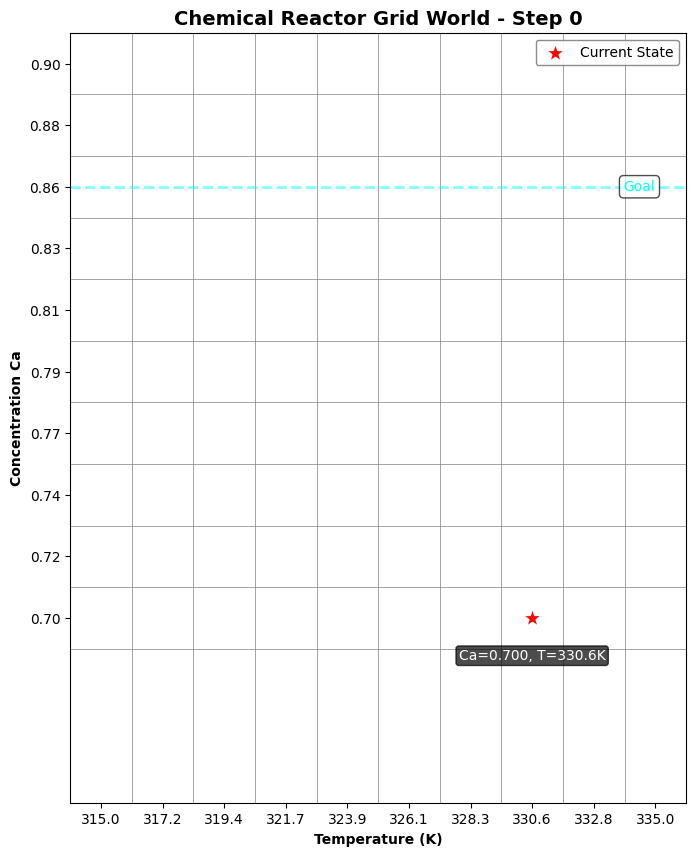

In [ ]:
ani = disc_env.animate_rollout(save_path="q_learning_animation.gif")

<img src="q_learning_animation.gif" width="750" align="center">